# Reproduce the Palma 2021 model

>Palma A, Iannuccelli M, Rozzo I, Licata L, Perfetto L, Massacci G, Castagnoli L, Cesareni G, Sacco F. Integrating Patient-Specific Information into Logic Models of Complex Diseases: Application to Acute Myeloid Leukemia. J Pers Med. 2021 Feb 10;11(2):117. doi: 10.3390/jpm11020117. PMID: 33578936; PMCID: PMC7916657.  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7916657/ 

**Goal:**
   
Develop strategies to exploit large-scale patient genomic information to infer clinical outcomes and design effective personalized therapy.

**Knowledge source:**
  
1. Genes frequently mutated in AML as listed by four international sequencing consortia or online resources: 
The TCGA AML dataset, consisting of genomic data of 200 clinically annotated adult cases of de novo AML patients. Fifty cases were characterized by whole-genome sequencing while for the remaining 150 only the exomes were sequenced [ref].   
2. Papaemmanuil et al., NEJM 2016, reported the mutational profile of 111 cancer driver genes in 1540 patients enrolled in three clinical trials. For each patient cytogenetic and clinical data are also available [ref].
Cancer Gene Census, a continuously updated resource storing a manually expert-annotated catalogue of genes containing mutations that have been causally implicated in cancer onset or progression [ref].
3. DisGeNET, a resource containing one of the largest collections of gene lists associated with human diseases [ref]. The list of genes that this resource links to AML is very large (102 genes). We only considered the 33 genes significantly associated to AML (Score_dga > 0.02).
4. Literature review: expert consensus as extrapolated from highly cited reviews
The causal relationships annotated in the SIGNOR database

**Representation:**
  
Boolean network
https://signor.uniroma2.it/CancerGeneNet/    
AML drivers are connected in a signed directed logic network to the three hallmark phenotypes. Each node and edge is color-coded as described in the legend.

**Tools:**
  
CancerGeneNet, a tool implemented in SIGNOR to connect the disease genes to hallmark disease phenotypes by causal relationships, obtaining a naïve network of cause–effect interactions
R package Boolnet to assemble the model and to compute its steady states

**in silico validation:**
  
Simulations were performed for different genomic profiles, to evaluate whether these models infer clinical outcomes of patients. To this end they made use of the clinical information provided by Papaemmanuil et al. reporting the impact of somatic mutations on overall survival and compared the mutation-specific hazard ratios with the predictions of the models.

In [1]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
#import pyboolnet # for reproduce the original results
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
from matplotlib.colors import ListedColormap

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

## Regulatory graph visualization with GINsim

The model is downloaded from the [Biodivine Boolean Models (BBM) Benchmark Dataset](https://github.com/sybila/biodivine-boolean-models/tree/main/models/%5Bid-100%5D__%5Bvar-18%5D__%5Bin-3%5D__%5BACUTE-MYELOID-LEUKEMIA%5D),which is taken directly from the text in the paper.

First visualize the network model.   
 

In [3]:
lqm = biolqm.load("../../Models/Palma2021_phe.sbml")
lrg = biolqm.to_ginsim(lqm)
ginsim.show(lrg)

## Boolean network simulations of the model

As described in the paper:  
>In silico simulations were performed for different genomic profiles, including loss of function of NPM1 and/or DNMT3A and/or gain of function of FLT3. In our Boolean model simulation, oncogenes and TSG were set to fixed values of 1 and 0, respectively. Each node of the network is associated to a Boolean expression, describing how the value of the node changes depending on the activities of the upstream regulatory nodes. Nonmutated genes were considered active or inactive depending on the activities of the upstream regulatory no
des. This approach enabled to generate eight “mutation-specific” models. To estimate the level of activation of each phenotype, we assumed that the activities of the nodes directly linked to a phenotype have an additive effect on the value of the phenotype. Hence, we estimated phenotype activation by adding up the contribution of the upstream activators and subtracting that of the upstream inhibitors. Thus, a phenotype is considered “most active” whenever all activator nodes are on and inhibitors off at a steady state (Figure 5).

![Figure 5](figure5.png)  

We are going to reproduce these results.

### Phenotype scores
>To estimate the level of activation of each phenotype, we assumed that the activities of the nodes directly linked to a phenotype have an additive effect on the value of the phenotype. Hence, we estimated phenotype activation by adding up the contribution of the upstream activators and subtracting that of the upstream inhibitors. Thus, a phenotype is considered “most active” whenever all activator nodes are on and inhibitors off at a steady state.

### Functions
In the original paper, R package Boolnet is used to assemble the model and to compute its steady states. Here we adopt a different approach using a Python library.

Starting with an initial state (by default where all components are inactive), we can compute the evolution of all components over time by evaluating the logical functions of the model. The `biolqm.trace` function returns an iterator from which we can obtain a list of successive states.  
  
Arguments to specify simulation parameters:
* `-u` for the updating mode (synchronous by default, can also be sequential)
* `-i` for the initial state (following the internal component ordering)
* `-m` for the maximal number of steps.  
  
These simulations are limited to deterministic updating modes, where each state has a single successor. The simulation stops when reaching a stable state or a maximal number of steps (1000 by default).  

For a simpler case, the `biolqm.fixpoints` function could be used to compute the complete list of logical stable states (or fixpoints) of the model.

### Model preprocess
In order to calculate the phenotype scores quantitatively, the 'Apoptosis', 'Differentiation' and 'Proliferation' nodes are removed from the network, and calculate later.   
I have manually edited the model in my desktop GINsim since it is not supported in this python module, and uploaded it to this docker image.

In [2]:
# import the model with no phenotype node (to calculate later)
palma_lqm = biolqm.load("../../Models/Palma2021.sbml")

# visualize
palma_lrg = biolqm.to_ginsim(palma_lqm)
ginsim.show(palma_lrg)

### Experiment set-up
According to the paper, we are going to set up the simulations on each conditions: 
>loss of function of NPM1 and/or DNMT3A and/or gain of function of FLT3.  
>(oncogenes and TSG were set to fixed values of 1 and 0, respectively.)

In [3]:
# set the fix value for the simulations
wt = biolqm.perturbation(palma_lqm, "FLT3%0 DNMT3A%1 NPM1%1")
flt3 = biolqm.perturbation(palma_lqm, "FLT3%1 DNMT3A%1 NPM1%1")
npm1 = biolqm.perturbation(palma_lqm, "FLT3%0 DNMT3A%1 NPM1%0")
dnmt3a = biolqm.perturbation(palma_lqm, "FLT3%0 DNMT3A%0 NPM1%1")
npm1_dnmt3a = biolqm.perturbation(palma_lqm,"FLT3%0 DNMT3A%0 NPM1%0")
flt3_dnmt3a = biolqm.perturbation(palma_lqm, "FLT3%1 DNMT3A%0 NPM1%1")
flt3_npm1 = biolqm.perturbation(palma_lqm, "FLT3%1 DNMT3A%1 NPM1%0")
flt3_npm1_dnmt3a = biolqm.perturbation(palma_lqm, "FLT3%1 DNMT3A%0 NPM1%0")

### Stable states calculation

In [14]:
# get the stable states
networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
results = pd.DataFrame()
for network in networks:
    fps = biolqm.fixpoints(network)
    results = pd.concat([results, pd.DataFrame(fps)],ignore_index=True)
results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]

The logical rules of the phenotypes:
- Apoptosis = tp53 & !bcl2
- Differentiation =	(cebpa | etv6) & !meis1, scale
- Proliferation	= (myc | ccnd1 | sox4 | meis1 | stat5a), scale

According to the data processing file the authors provide, the phenotype scores would be:
- Apoptosis = tp53 - bcl2
- Differentiation =	cebpa + etv6 - meis1
- Proliferation	= ccnd1 + sox4 + meis1 + stat5a
    
Here myc is excluded from the calculation of proliferation score. I am not sure if it is intentional or accidental.

In [15]:
# calculate the phenotype scores
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']

# calculate the network scores
results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
results = results.T.sort_index()
results

,wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a
AKT1,0,1,0,0,0,1,1,1
APOPTOSIS,1,1,0,1,0,1,-1,-1
BCL2,0,0,0,0,0,0,1,1
CCND1,0,0,0,0,0,1,0,1
CDKN2A,1,1,0,1,0,1,0,0
CEBPA,1,0,1,1,1,0,0,0
DIFFERENTIATION,2,0,2,2,1,0,0,-1
DNMT3A,1,1,1,0,0,0,1,0
ETV6,1,0,1,1,1,0,0,0
FBXW7,1,1,0,1,0,1,0,0


### Comparison


In [16]:
# compare with Palma etal. 's results
palma_results = pd.read_csv('Palma2021_results.csv',index_col = 0)
palma_results.index = palma_results.index.str.upper()
palma_results.sort_index(inplace=True)
palma_results.columns = results.columns.values
difference = results - palma_results
difference.style.background_gradient(cmap='Purples')

,wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a
AKT1,0,0,0,0,0,0,0,0
APOPTOSIS,0,0,0,0,0,0,0,0
BCL2,0,0,0,0,0,0,0,0
CCND1,0,0,0,0,0,0,0,0
CDKN2A,0,0,0,0,0,0,0,0
CEBPA,0,0,0,0,0,0,0,0
DIFFERENTIATION,0,0,0,0,0,0,0,0
DNMT3A,0,0,0,0,0,0,0,0
ETV6,0,0,0,0,0,0,0,0
FBXW7,0,0,0,0,0,0,0,0


The only difference is 'myc' in the FLT3 mutation experiment, where our simulation gets a 1 and Palma et al.'s gets a 0.   

The update rules of myc:  
> myc = erk & !(fbxw7 & gsk3b)

Since here erk = 1, fbxw7 = 1 and gsk3b = 0, myc should be 1. I believe they had made a mistake here.

## Validation
### Harzard ratio for death
>We next evaluated whether we could use these models to infer some clinical outcomes of patients carrying mutations in NPM1 and/or DNMT3A and/or FLT3. To this end we made use of the clinical information provided by Papaemmanuil et al. reporting the impact of somatic mutations on overall survival and we compared the mutation-specific hazard ratios with the predictions of our models. As a proxy for the predictive power of our model, we defined the “integrated network phenotype” score, which is calculated by subtracting from the activation value of the phenotype “proliferation” the values of “apoptosis” and “differentiation”.

In [17]:
# Import the the mutation-specific hazard ratios provided by Papaemmanuil et al.
hazard_ratio = pd.read_csv('../../Data/AMLSG/Hazard Ratio for Death.csv')
hazard_ratio.index = ['Hazard_ratio']
results = pd.concat([hazard_ratio,results])

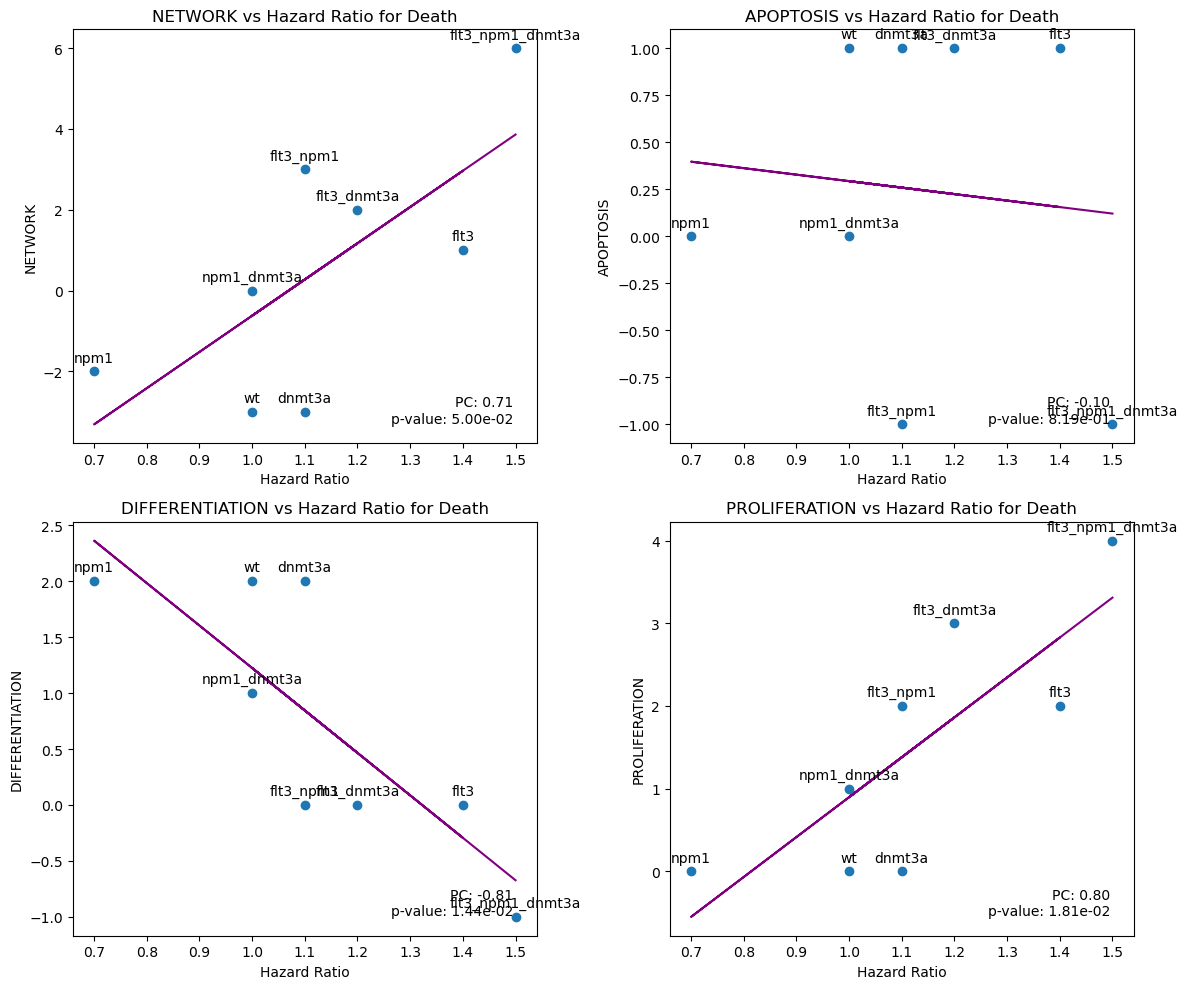

In [18]:
# Plotting scatterplots
phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, phenotype in enumerate(phenotypes):
    ax = axes[i // 2, i % 2]
    # Extract hazard ratio and phenotype values
    x = results.loc['Hazard_ratio', :]
    y = results.loc[phenotype, :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title(f'{phenotype} vs Hazard Ratio for Death')
    ax.set_xlabel('Hazard Ratio')
    ax.set_ylabel(phenotype)

    # Annotate each data point
    for j in range(len(x)):
        label = y.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
            transform=ax.transAxes, horizontalalignment='right')
    
plt.tight_layout()
plt.show()

    
Compared with Figure 6 from the paper:  
![Figure 6-1](Figure6-1.png) 

**The phenotype scores correlate significantly with the death hazard ratio except for 'apoptosis', which matches the results from the paper.**   
However, there is minor error in the figure. A hazard ratio of 0 here in their figure would imply that the event (death, in this case) never occurs in the group being studied, which is highly unlikely in a clinical context, especially for a condition like AML. 

### Clinical outcomes
>We next investigated the prognostic power of our model by comparing it with additional clinical features derived from the AML TGCA dataset. Specifically, we compared the mutation-specific peripheral blood (PB) and bone marrow (BM) blast percentages with the predictions of our models.
   
Mutation and clinical data are obtained from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [19]:
# Data file path
tsv_file_path_genes = 'https://api.gdc.cancer.gov/data/0d8851d7-1af0-4054-a527-5db763138400'
tsv_file_path_clinical = 'https://api.gdc.cancer.gov/data/1fd61a91-90d5-405a-bcef-b9df8b396a21'

# Mutation data
df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])

# clinical data 
df_clinical = pd.read_csv(tsv_file_path_clinical, sep='\t', usecols=['bcr_patient_barcode', 
                                                            'lab_procedure_blast_cell_outcome_percentage_value',
                                                            'lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

# Function to determine mutation combination
def determine_combination(row):
    genes = row['gene_name']
    has_flt3 = 'FLT3' in genes
    has_npm1 = 'NPM1' in genes
    has_dnmt3a = 'DNMT3A' in genes

    if has_flt3 and has_npm1 and has_dnmt3a:
        return "flt3_npm1_dnmt3a"
    elif has_flt3 and has_dnmt3a:
        return "flt3_dnmt3a"
    elif has_flt3 and has_npm1:
        return "flt3_npm1"
    elif has_npm1 and has_dnmt3a:
        return "npm1_dnmt3a"
    elif has_flt3:
        return "flt3"
    elif has_npm1:
        return "npm1"
    elif has_dnmt3a:
        return "dnmt3a"
    else:
        return "wt"

# Group by TCGA_id and apply the combination function
grouped = df_genes.groupby('TCGA_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(df_clinical, grouped[['TCGA_id', 'mutation']], left_on='bcr_patient_barcode', right_on='TCGA_id')
clinical_result = clinical_result[['TCGA_id', 'mutation', 
                   'lab_procedure_blast_cell_outcome_percentage_value',
                   'lab_procedure_bone_marrow_blast_cell_outcome_percent_value']]

print(clinical_result)

          TCGA_id     mutation  \
0    TCGA-AB-2802  npm1_dnmt3a   
1    TCGA-AB-2803           wt   
2    TCGA-AB-2804           wt   
3    TCGA-AB-2805           wt   
4    TCGA-AB-2806           wt   
..            ...          ...   
192  TCGA-AB-3007         flt3   
193  TCGA-AB-3008           wt   
194  TCGA-AB-3009           wt   
195  TCGA-AB-3011         npm1   
196  TCGA-AB-3012           wt   

     lab_procedure_blast_cell_outcome_percentage_value  \
0                                                   88   
1                                                   44   
2                                                   82   
3                                                   67   
4                                                   90   
..                                                 ...   
192                                                 90   
193                                                 71   
194                                                 51   
195        

In [20]:
# convert to numeric
clinical_result['lab_procedure_blast_cell_outcome_percentage_value'] = pd.to_numeric(clinical_result['lab_procedure_blast_cell_outcome_percentage_value'])
clinical_result['lab_procedure_bone_marrow_blast_cell_outcome_percent_value'] = pd.to_numeric(clinical_result['lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

# aggregate the mean PB of each mutation profile
clinical_aggr = clinical_result.pivot_table(
    index='mutation', 
    values=['lab_procedure_blast_cell_outcome_percentage_value','lab_procedure_bone_marrow_blast_cell_outcome_percent_value'],
    aggfunc='mean'
)
clinical_aggr.columns = ['PB_BLAST', 'BM_BLAST']
clinical_aggr.to_csv('clinical.csv')
clinical_aggr

,PB_BLAST,BM_BLAST
mutation,,
dnmt3a,63.473684,33.421053
flt3,72.090909,44.681818
flt3_dnmt3a,73.600000,48.000000
flt3_npm1,73.750000,46.166667
flt3_npm1_dnmt3a,76.882353,44.176471
npm1,76.500000,53.714286
npm1_dnmt3a,68.909091,31.636364
wt,60.329897,29.061856


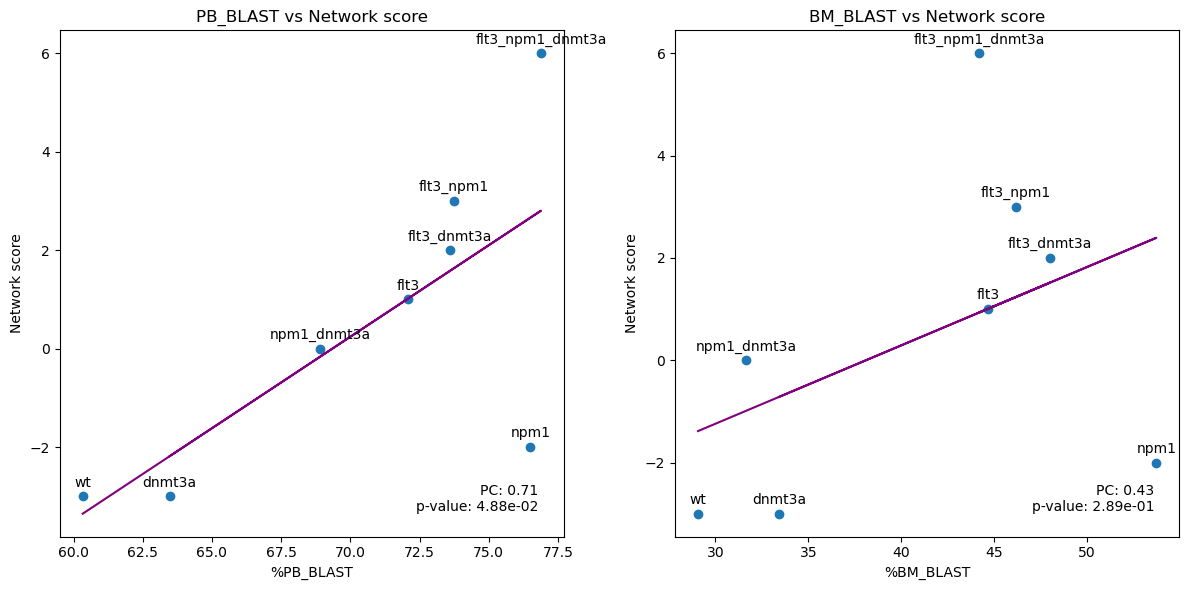

In [21]:
# Merge the results table
clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),results.sort_index(axis=1)])

# Plotting scatterplots
clinicals = ['PB_BLAST', 'BM_BLAST']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, clinical in enumerate(clinicals):
    ax = axes[i]
    # Extract network scores and clinical outcome values
    y = clinical_results.loc['NETWORK', :]
    x = clinical_results.loc[clinical, :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title(f'{clinical} vs Network score')
    ax.set_ylabel('Network score')
    ax.set_xlabel('%' + clinical)

        # Annotate each data point
    for j in range(len(x)):
        label = y.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')

    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
            transform=ax.transAxes, horizontalalignment='right')
    
plt.tight_layout()
plt.show()

Compared with Figure 6 from the paper:  
![Figure 6-1](Figure6-2.png) 

**There result is not very consistent, Pearson Correlation: 0.71 vs 0.82 for peripheral blood (PB) blast percentages and 0.43 vs 0.83 bone marrow (BM) blast percentages.**  
However, it is also unlikely that blast percentages would be 0 for wild type patients. They did not give the link of dataset they used here, and it is thus possible that different version/indicators might be used.

## Conclusion
**Results from the Palma et al. 2021 are generally reproducible, expect minor errors in the paper.**   
However, there is a lack of detailed descriptions in the paper, including the simulation parameters and data processing steps. One needs to contact the authors to obtain those details in order to fully reproduce their results.

## Clustering the stable states

In [15]:
model_name = "Palma2021"
net = boolnet.loadNetwork(model_name + ".txt")
attr = boolnet.getAttractors(net)
print(attr)

Attractor 1 is a simple attractor consisting of 1 state(s) and has a basin of 262144 state(s):

 |--<--------------------|
 V                       |
 000000010001011101000   |
 V                       |
 |-->--------------------|


Genes are encoded in the following order: FLT3 NPM1 AKT1 APOPTOSIS BCL2 CCND1 CDKN2A CEBPA DIFFERENTIATION DNMT3A MAPK1 ETV6 FBXW7 GSK3B HOXA9 MEIS1 MYC PROLIFERATION SOX4 STAT5A TP53

Attractor 2 is a simple attractor consisting of 1 state(s) and has a basin of 262144 state(s):

 |--<--------------------|
 V                       |
 101011000010001111110   |
 V                       |
 |-->--------------------|


Genes are encoded in the following order: FLT3 NPM1 AKT1 APOPTOSIS BCL2 CCND1 CDKN2A CEBPA DIFFERENTIATION DNMT3A MAPK1 ETV6 FBXW7 GSK3B HOXA9 MEIS1 MYC PROLIFERATION SOX4 STAT5A TP53

Attractor 3 is a simple attractor consisting of 1 state(s) and has a basin of 262144 state(s):

 |--<--------------------|
 V                       |
 0101001110011

In [16]:
# Activate the conversion context to use pandas DataFrame
pandas2ri.activate()

# Access the dataframe stored under the key '1'
attrr = boolnet.plotAttractors(attr)
r_df = attrr.rx2('1')

# Use the local converter context to manage the conversion to a numpy array
with localconverter(robjects.default_converter + pandas2ri.converter):
    np_array = np.array(r_df)

# Extract names from the R dataframe
row_names = list(r_df.rownames)
column_names = list(r_df.colnames)

# Create a pandas DataFrame from the numpy array
df = pd.DataFrame(np_array, index=row_names, columns=column_names)

df = df.T
df.index = df.index.str.replace('Attr', 'S')
df.to_csv('../SimulationResults/attr_' + model_name + '.csv')
df

,FLT3,NPM1,AKT1,APOPTOSIS,BCL2,CCND1,CDKN2A,CEBPA,DIFFERENTIATION,DNMT3A,MAPK1,ETV6,FBXW7,GSK3B,HOXA9,MEIS1,MYC,PROLIFERATION,SOX4,STAT5A,TP53
S1.1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,0,0
S2.1,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,0
S3.1,0,1,0,1,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1
S4.1,1,1,1,1,0,1,1,0,0,0,1,0,1,0,0,0,1,1,1,1,1
S5.1,0,0,0,0,0,0,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0
S6.1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,1,1,1,0
S7.1,0,1,0,1,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1
S8.1,1,1,1,1,0,0,1,0,0,1,1,0,1,0,0,0,1,1,1,1,1


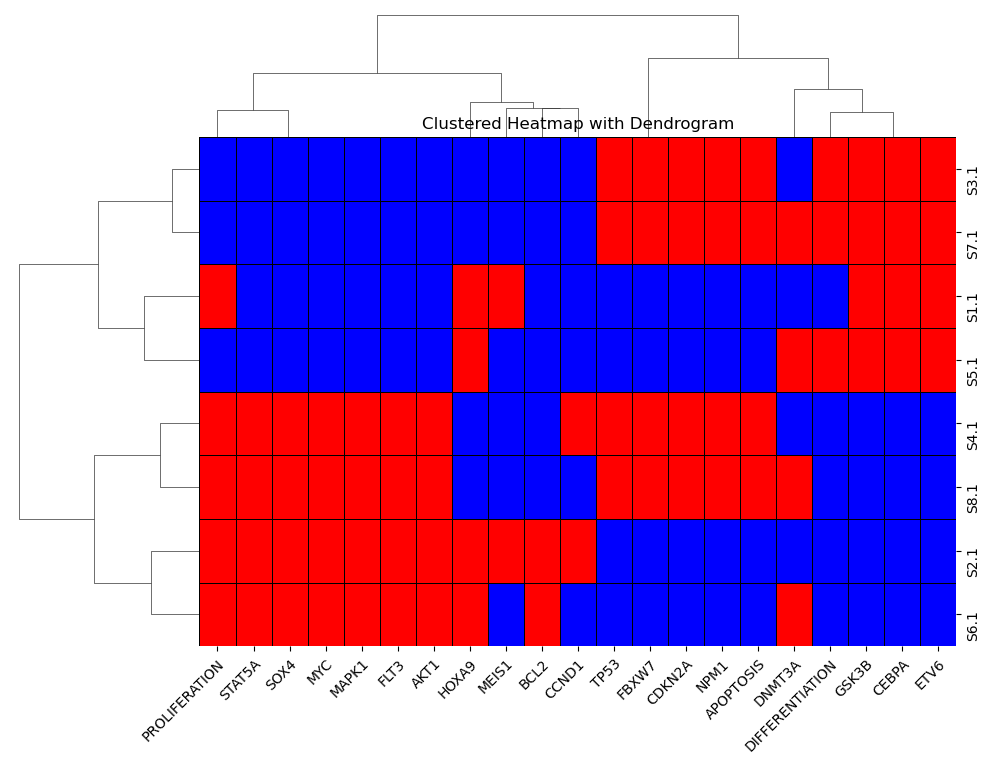

In [18]:
# Clustering
cmap = ListedColormap(['blue', 'red'])

g = sns.clustermap(df, method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(10, 8), cbar=False, col_cluster=True)
g.ax_heatmap.set_title('Clustered Heatmap with Dendrogram')
g.ax_heatmap.tick_params(axis='y', labelsize=10)  # Adjust y-tick label size if needed
g.ax_heatmap.tick_params(axis='x', labelsize=10)  # Adjust x-tick label size if needed, rotate if necessary
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels for better readability

# Hide the color bar space if it's not needed
g.cax.set_visible(False)

plt.show()

In [20]:
print(boolnet.getAttractors(net, type="asynchronous"))

Attractor 1 is a simple attractor consisting of 1 state(s):

 |--<--------------------|
 V                       |
 101010000110001011110   |
 V                       |
 |-->--------------------|


Genes are encoded in the following order: FLT3 NPM1 AKT1 APOPTOSIS BCL2 CCND1 CDKN2A CEBPA DIFFERENTIATION DNMT3A MAPK1 ETV6 FBXW7 GSK3B HOXA9 MEIS1 MYC PROLIFERATION SOX4 STAT5A TP53

Attractor 2 is a simple attractor consisting of 1 state(s):

 |--<--------------------|
 V                       |
 010100111101110000001   |
 V                       |
 |-->--------------------|


Genes are encoded in the following order: FLT3 NPM1 AKT1 APOPTOSIS BCL2 CCND1 CDKN2A CEBPA DIFFERENTIATION DNMT3A MAPK1 ETV6 FBXW7 GSK3B HOXA9 MEIS1 MYC PROLIFERATION SOX4 STAT5A TP53

Attractor 3 is a simple attractor consisting of 1 state(s):

 |--<--------------------|
 V                       |
 101011000010001111110   |
 V                       |
 |-->--------------------|


Genes are encoded in the following o